In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
df = pd.read_csv(r"C:\Users\Moitree\Downloads\Restaurant rating prediction\Dataset  (1).csv")

In [11]:
# Drop irrelevant columns
df_model = df.drop(columns=[
    "Restaurant ID", "Restaurant Name", "Address", "Locality", "Locality Verbose",
    "Longitude", "Latitude", "Rating color", "Rating text"
])

df_model["Cuisines"] = df_model["Cuisines"].fillna("Unknown")




In [12]:
#  Seperate features and target
X = df_model.drop(columns=["Aggregate rating"])
y = df_model["Aggregate rating"]


In [13]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [14]:
# Define transformer
numerical_transformer = SimpleImputer(strategy="mean")
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])
#combine preprocessors
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [15]:
# Create pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Country Code',
                                                   'Average Cost for two',
                                                   'Price range', 'Votes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['City', 'Cuisines',
                                                   'Currency',
                                                   'Has Table booking',
                                                   'Has Online delivery',
                                                   'Is delivering now',
                                                   'Switch to order menu'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [18]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f" Model Evaluation:\nMSE = {mse:.3f}\nR² Score = {r2:.3f}")


 Model Evaluation:
MSE = 0.101
R² Score = 0.956


In [20]:
# Analyze feature importence
importances = model.named_steps["regressor"].feature_importances_
onehot_features = model.named_steps["preprocessor"].transformers_[1][1]\
    .named_steps["onehot"].get_feature_names_out(categorical_cols)

feature_names = list(numerical_cols) + list(onehot_features)
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

top_features=feature_importance.head(10)


for feature, score in top_features.items():
    print(f"{feature:<35} ➜  {score:.4f}")

Votes                               ➜  0.9494
Average Cost for two                ➜  0.0065
Country Code                        ➜  0.0065
City_New Delhi                      ➜  0.0013
Currency_Indian Rupees(Rs.)         ➜  0.0013
Price range                         ➜  0.0012
City_Noida                          ➜  0.0011
Cuisines_North Indian, Chinese      ➜  0.0009
Has Online delivery_No              ➜  0.0008
Has Online delivery_Yes             ➜  0.0008


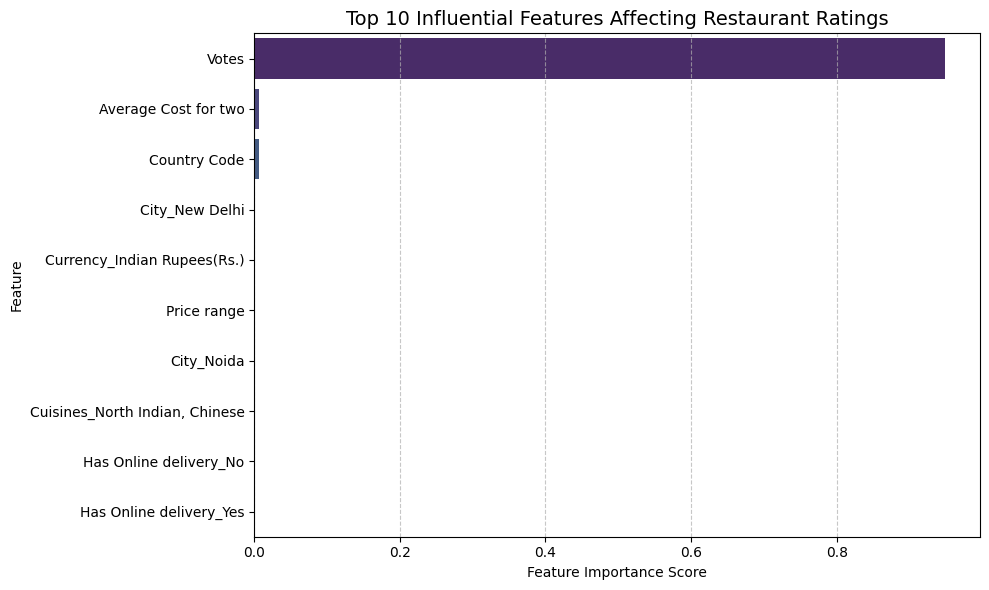

In [21]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.head(10).values, y=feature_importance.head(10).index, palette="viridis")
plt.title("Top 10 Influential Features Affecting Restaurant Ratings", fontsize=14)
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

In [22]:
#save the model
import joblib
joblib.dump(model,"Resturant_rating_model.pkl")

print("model is saved successfully")


model is saved successfully


In [23]:
# Prediction function
def predict_rating(user_input: dict):
    input_df = pd.DataFrame([user_input])
    predicted_rating = model.predict(input_df)[0]
    return round(predicted_rating, 2)


In [24]:
# Example input
example_input = {
    "Country Code": 162,
    "City": "New Delhi",
    "Cuisines": "North Indian, Mughlai",
    "Average Cost for two": 800,
    "Currency": "Indian Rupees(Rs.)",
    "Has Table booking": "Yes",
    "Has Online delivery": "Yes",
    "Is delivering now": "No",
    "Switch to order menu": "No",
    "Price range": 3,
    "Votes": 500
}

# Predict and display result
predicted = predict_rating(example_input)
print(f"Predicted Restaurant Rating: {predicted}")

Predicted Restaurant Rating: 4.12


In [25]:
example_input = {
    "Country Code": 162,
    "City": "Mumbai",
    "Cuisines": "seafood",
    "Average Cost for two": 1200,
    "Currency": "Indian Rupees(Rs.)",
    "Has Table booking": "no",
    "Has Online delivery": "no",
    "Is delivering now": "No",
    "Switch to order menu": "No",
    "Price range": 4,
    "Votes": 900
}

# Predict and display result
predicted = predict_rating(example_input)
print(f"Predicted Restaurant Rating: {predicted}")

Predicted Restaurant Rating: 4.33
